# Exercises

We have four exercises in this section:
1. Rewrite the CART method to the Gini index.
2. Use pydot do draw the tree for C4.5 example.
3. Implement the minimum number of objects pruning method.
4. Plot OC1 tree, but instead of elements id, print the feature id it was split by.

## Exercise 1: Rewrite the CART method to use Gini index as shown in the lecture

Use Gini index can be calculated with the following equation:
\begin{equation}
I_{G}(X)=1-\sum_{i=1}^{m}p^{2}_{i},
\end{equation}
and
\begin{equation}
I_{G}(\text{feature})=\sum_{i=1}^{n}p_{i}*I_{G}(X_{i}).
\end{equation}

You need to fill the ``calculate_gini`` function and change the ``build`` function a bit.

In [2]:
import math
import numpy as np
import pydot
import copy
import pandas as pd

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]
df = pd.DataFrame(data=data_set, columns=['Location','Category','Gender','Product review'])
df['Label'] = labels
df

,Location,Category,Gender,Product review,Label
0,1,1,2,2,1
1,2,1,2,2,1
2,1,1,1,2,-1
3,1,2,1,2,1
4,2,3,2,2,-1
5,2,2,1,2,-1
6,3,2,2,1,1
7,1,3,2,2,1
8,3,3,2,1,1
9,2,3,1,2,1


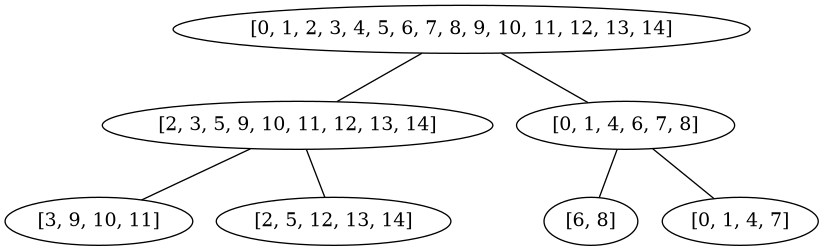

In [3]:
from dataclasses import dataclass, field
from typing import Set, NamedTuple, FrozenSet
from functools import cached_property, partialmethod
from __future__ import annotations
from collections import deque

class Feature(NamedTuple):
    name: str
    value: FrozenSet[int]
        
@dataclass
class Node:
    feature: Feature
    _mask: pd.Series
    left: Node = None
    right: Node = None
    _used: Set[Feature] = field(default_factory=set)
    
    
@dataclass
class CART:
    dataset: pd.DataFrame
    root: Node = None
        
    @cached_property
    def features(self):
        return set(self.dataset.columns)
    
    def unique_values(self, feature: str):
        return set(np.unique(self.dataset[feature].values))
    
    Labels = partialmethod(unique_values, 'Label')
    
    @cached_property
    def labels(self):
        return self.Labels()
    
    def gini(self, node: Node, feature: str):
        # if the node contains the points from the same class, don't split it
        if any(sum((node._mask & (self.dataset['Label'] == i))) == sum(node._mask)\
               for i in self.labels):
            return (None, None)
        ginies = []
        for value in self.unique_values(feature):
            # check if the pair (feature, value) has not been used to split the node previously
            if Feature(feature, frozenset({value})) not in node._used:
                points_left_mask = (node._mask) & (self.dataset[feature]==value)
                points_right_mask = (node._mask) & ~(self.dataset[feature]==value)
                
                if sum(points_left_mask) >= 2:
                    gini_left = 1 - sum(
                        (sum((points_left_mask & (self.dataset['Label'] == i))) / sum(points_left_mask)) ** 2 \
                            for i in self.labels
                    )
                else:
                    return (None, None)
                    
                if sum(points_right_mask) >= 2:
                    gini_right = 1 - sum(
                        (sum((points_right_mask & (self.dataset['Label'] == i))) / sum(points_right_mask)) ** 2 \
                            for i in self.labels
                    )
                else:
                    return (None, None)
                
                if sum(node._mask) < 2:
                    return (None, None)

                l_coef = sum(points_left_mask) / sum(node._mask) 
                r_coef = sum(points_right_mask) / sum(node._mask)
                ginies.append((l_coef * gini_left + r_coef * gini_right, value))
            
        return min(ginies, key=lambda x: x[0]) if ginies else (None, None)
            
            
    def build(self):
        root = Node(
            feature=None,
            _mask=pd.Series(True, index=self.dataset.index)
        )
        self.root = root
        queue = deque()
        queue.appendleft(self.root)
        while not len(queue) == 0:
            node = queue.pop()
            for feature in self.features:
                gini, value = self.gini(node, feature)
                if value:
                    node.left = Node(
                        feature=Feature(feature, frozenset({value, })),
                        _mask=node._mask & (self.dataset[feature] == value),
                        _used = node._used | { Feature(feature, frozenset({value, }))},
                    )
                    node.right = Node(
                        feature=Feature(feature, frozenset(self.unique_values(feature) - {value, })),
                        _mask=node._mask & ~(self.dataset[feature] == value),
                        _used = node._used | { Feature(feature, frozenset({value, }))}
                    )
                    break
            if node.left:
                queue.appendleft(node.left)
            if node.right:
                queue.appendleft(node.right)
                  
tree = CART(df)
tree.build()

def split_history(tree):
    queue = deque()
    queue.appendleft(tree.root)
    
    while not len(queue) == 0:
        node = queue.pop()
        if node.left:
            yield [str(list(df[node._mask].index)), str(list(df[node.left._mask].index))]
            queue.appendleft(node.left)
        if node.right:
            yield [str(list(df[node._mask].index)), str(list(df[node.right._mask].index))]
            queue.appendleft(node.right)
            
        
def plot_tree(cart):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history(cart):
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('cart_tree_ex.png', format='png')

plot_tree(tree)
from IPython.display import Image
Image(filename='cart_tree_ex.png') 

## Exercise 2: Use pydot do draw the tree for C4.5 example

Fill the code below.

In [4]:
%store -r split_history_c45

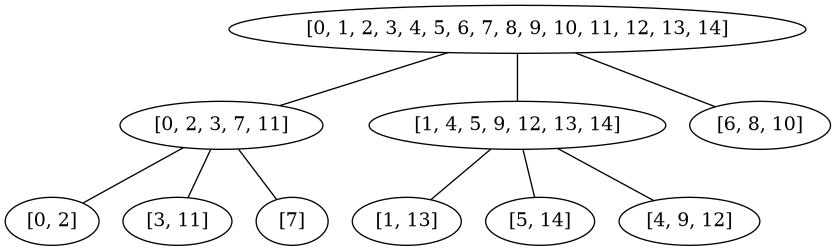

In [5]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('c45_tree.png', format='png')
    
plot_tree(split_history_c45)

from IPython.display import Image
Image(filename='c45_tree.png') 

## Exercise 3: Implement the minimum number of objects pruning method

The MNO method checkes the accuracy at each split and prune the node if the number of objects in a leaf is below a given value N. Load the CART method first as below.

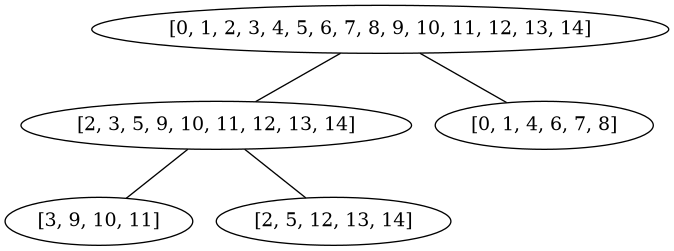

In [6]:
from dataclasses import dataclass, field
from typing import Set, NamedTuple, FrozenSet
from functools import cached_property, partialmethod
from __future__ import annotations
from collections import deque

class Feature(NamedTuple):
    name: str
    value: FrozenSet[int]
        
@dataclass
class Node:
    feature: Feature
    _mask: pd.Series
    left: Node = None
    right: Node = None
    _used: Set[Feature] = field(default_factory=set)

N = 3
    
@dataclass
class CART:
    dataset: pd.DataFrame
    root: Node = None
        
    @cached_property
    def features(self):
        return set(self.dataset.columns)
    
    def unique_values(self, feature: str):
        return set(np.unique(self.dataset[feature].values))
    
    Labels = partialmethod(unique_values, 'Label')
    
    @cached_property
    def labels(self):
        return self.Labels()
    
    def gini(self, node: Node, feature: str):
        if any(sum((node._mask & (self.dataset['Label'] == i))) == sum(node._mask)\
               for i in self.labels):
            return (None, None)
        ginies = []
        for value in self.unique_values(feature):
            if Feature(feature, frozenset({value})) not in node._used:
                points_left_mask = (node._mask) & (self.dataset[feature]==value)
                points_right_mask = (node._mask) & ~(self.dataset[feature]==value)
                
                if sum(points_left_mask) >= N:
                    gini_left = 1 - sum(
                        (sum((points_left_mask & (self.dataset['Label'] == i))) / sum(points_left_mask)) ** 2 \
                            for i in self.labels
                    )
                else:
                    return (None, None)
                    
                if sum(points_right_mask) >= N:
                    gini_right = 1 - sum(
                        (sum((points_right_mask & (self.dataset['Label'] == i))) / sum(points_right_mask)) ** 2 \
                            for i in self.labels
                    )
                else:
                    return (None, None)
                
                if sum(node._mask) < N:
                    return (None, None)

                l_coef = sum(points_left_mask) / sum(node._mask) 
                r_coef = sum(points_right_mask) / sum(node._mask)
                ginies.append((l_coef * gini_left + r_coef * gini_right, value))
            
        return min(ginies, key=lambda x: x[0]) if ginies else (None, None)
            
            
    def build(self):
        root = Node(
            feature=None,
            _mask=pd.Series(True, index=self.dataset.index)
        )
        self.root = root
        queue = deque()
        queue.appendleft(self.root)
        while not len(queue) == 0:
            node = queue.pop()
            for feature in self.features:
                gini, value = self.gini(node, feature)
                if value:
                    node.left = Node(
                        feature=Feature(feature, frozenset({value, })),
                        _mask=node._mask & (self.dataset[feature] == value),
                        _used = node._used | { Feature(feature, frozenset({value, }))},
                    )
                    node.right = Node(
                        feature=Feature(feature, frozenset(self.unique_values(feature) - {value, })),
                        _mask=node._mask & ~(self.dataset[feature] == value),
                        _used = node._used | { Feature(feature, frozenset({value, }))}
                    )
                    break
            if node.left:
                queue.appendleft(node.left)
            if node.right:
                queue.appendleft(node.right)
                  
tree = CART(df)
tree.build()

def split_history(tree):
    queue = deque()
    queue.appendleft(tree.root)
    
    while not len(queue) == 0:
        node = queue.pop()
        if node.left:
            yield [str(list(df[node._mask].index)), str(list(df[node.left._mask].index))]
            queue.appendleft(node.left)
        if node.right:
            yield [str(list(df[node._mask].index)), str(list(df[node.right._mask].index))]
            queue.appendleft(node.right)
            
        
def plot_tree(cart):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history(cart):
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('cart_tree_ex.png', format='png')

plot_tree(tree)
Image(filename='cart_tree_ex.png') 

## Exercise 4: Plot OC1 tree, but instead of elements id, print the feature id it was split by

To make the task done, you need to change the functions:
- ``build_level``,
- update the ``BinaryLeaf`` in two places to add the setters/getters and the feature and feature value split data.


<ipython-input-17-19d8876f621a>:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  am = np.array(am)


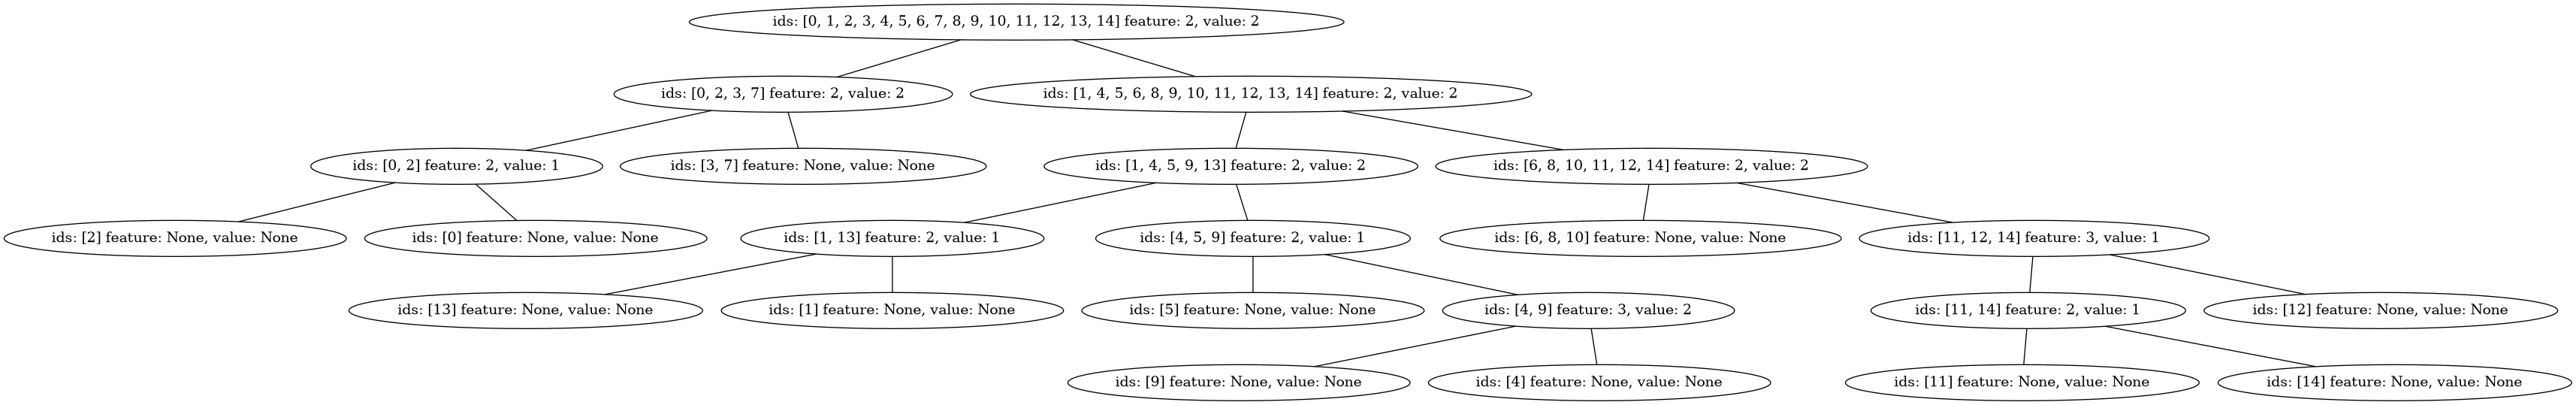

In [17]:
from random import randint
from random import random 

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.p = None
        self.elements = elements
        # add here features and values
        self.labels = labels
        self.completed = False
        self.ids = ids
        self.feature = None
        self.feature_value = None

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    # fill the methods here

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids
    
    def set_feature(self, feature):
        self.feature = feature
    
    def get_feature(self, feature):
        return self.feature
    
    def set_feature_value(self, value):
        self.feature_value = value
    
    def get_feature_value(self):
        return self.feature_value

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root
R = 10

## helper methods:

def compute_v(element, scv):
    return np.sum(np.multiply(element, scv[:-1])) + scv[-1]

def compare_two_leafs(leaf1, leaf2):
    labels1 = leaf1.labels
    labels2 = leaf2.labels
    if len(labels1) == len(labels2):
        for i in range(len(labels1)):
            if labels1[i] != labels2[i]:
                return False
        return True
    return False

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

## oc1

def calculate_gini(labels):
    unique_labels = np.unique(labels)
    gini = 0
    for label in unique_labels:
        found = np.where(labels == label)
        gini = gini + len(found)/len(labels)
    return np.square(gini)

def get_all_possible_splits_by_gini(leaf):
    leaf_elements = leaf.elements
    labels = leaf.labels
    ginis = []
    for i in range(len(leaf_elements[0])):
        feature_ginis = []
        feature_column = np.array(leaf_elements)[:, i]
        for feature in feature_column:
            distinguish = feature_column <= feature
            left_labels  = np.array(labels)[distinguish]
            right_labels = np.array(labels)[~distinguish]
            gini = 1 - calculate_gini(left_labels) - calculate_gini(right_labels)
            feature_ginis.append([feature,gini])
        ginis.append(min(feature_ginis))
    return ginis


def find_current_level_data(root):
    return is_leaf_completed(root)

def divide_data_hiperplane(leaf,scv):
    below = []
    above = []
    below_labels = []
    above_labels = []
    below_ids = []
    above_ids = []
    for i in range(len(leaf.elements)):
        v = compute_v(leaf.elements[i],scv) > 0
        if v:
            above.append(leaf.elements[i])
            above_labels.append(leaf.labels[i])
            above_ids.append(leaf.ids[i])            
        else:
            below.append(leaf.elements[i])
            below_labels.append(leaf.labels[i])
            below_ids.append(leaf.ids[i])    
    return np.array(below), np.array(above), np.array(below_labels), np.array(above_labels), below_ids, above_ids

def get_coefficiency(splits):
    splits = np.array(splits)
    scv = np.zeros(len(splits)+1)
    min_split_index = np.argmin(splits[:,1])
    scv[min_split_index] = 1
    scv[-1] = -splits[min_split_index][1]
    return scv

def compute_u(element, scv, feature):
    return (scv[feature] * element[feature] - compute_v(element, scv)) / element[feature]

def sort_u(element):
    return np.sort(element)

def perturb(leaf, scv, feature, old_gini):
    u=[]
    for element in leaf.elements:
        u.append(compute_u(element, scv, feature))
    splits = sort_u(np.array(u))
    am = []
    for split in splits:
        new_scv = scv
        new_scv[feature] = split
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf, scv)
        gini = 1 - (calculate_gini(below_label) - calculate_gini(above_label))
        am.append([new_scv, gini])
    am = np.array(am)
    best_split_index = np.argmin(am[:,1])
    if am[best_split_index][1] < old_gini:
        return am[best_split_index][1], am[best_split_index][0]
    elif am[best_split_index][1] == old_gini:
        if random() < 0.3:
            return am[best_split_index][1], am[best_split_index][0]
    return old_gini, scv


def build_level(root, split_history):
    leaf = find_current_level_data(root)
    if leaf == None:
        return
    splits = get_all_possible_splits_by_gini(leaf)
    split_coefficiency_vector = get_coefficiency(splits)
    below,above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    gini = 1 - calculate_gini(below_label) - calculate_gini(above_label)
    for c in range(R):
        feature = randint(0,len(leaf.elements[0])-1)
        gini, split_coefficiency_vector = perturb(leaf, split_coefficiency_vector, feature, gini)
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    left_leaf = BinaryLeaf(below, below_label, below_ids)
    right_leaf = BinaryLeaf(above, above_label, above_ids)
    split_history.append([str(leaf.ids), str(left_leaf.ids)])
    split_history.append([str(leaf.ids), str(right_leaf.ids)])
    leaf.set_completed()
    # change here
    leaf.set_feature(feature)
    leaf.set_feature_value(root.elements[left_leaf.ids[0]][feature])
    ###
    if len(np.unique(below_label)) == 1:
        left_leaf.set_completed()
    if len(np.unique(above_label)) == 1:
        right_leaf.set_completed()
    if compare_two_leafs(leaf, left_leaf) or compare_two_leafs(leaf,right_leaf):
        leaf.set_completed()
    else:
        leaf.set_R(right_leaf)
        leaf.set_L(left_leaf)
    build_level(root, split_history)
    return root, split_history

def build(root):
    split_history = []
    return build_level(root, split_history)

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('oc1_tree.png', format='png')

oc1_tree, split_history = build(root)
# plot_tree(split_history)
def split_history(root):
    queue = deque()
    queue.appendleft(root)
    
    while not len(queue) == 0:
        node = queue.pop()
        if node.L:
            yield [f"ids: {node.ids} feature: {node.feature}, value: {node.feature_value}",\
                   f"ids: {node.L.ids} feature: {node.L.feature}, value: {node.L.feature_value}"]
            queue.appendleft(node.L)
        if node.R:
            yield [f"ids: {node.ids} feature: {node.feature}, value: {node.feature_value}",\
                   f"ids: {node.R.ids} feature: {node.R.feature}, value: {node.R.feature_value}"]
            queue.appendleft(node.R)
            
        
def plot_tree(root):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history(root):
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('oc1_tree_ex.png', format='png')

plot_tree(oc1_tree)
Image(filename='oc1_tree_ex.png') 